In [32]:
import torch
import open_clip
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
!pip install seaborn


In [33]:
# CELL 2: Imports + Load the model (runs on CPU automatically) – FIXED!

print("Model loaded on CPU – ready for zero-shot!")

# CELL 2: Load a FAST & STRONG modern CLIP model
import open_clip
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B/16',                      # Fastest strong architecture
    pretrained='openai'    # One of the best open models (2023+)
)
model.to(device)
model.eval()
print("Model loaded on CPU – ready for zero-shot!")


Model loaded on CPU – ready for zero-shot!
Model loaded on CPU – ready for zero-shot!


In [34]:
# CELL 3: CIFAR-10 classes + smart prompt ensemble (3 templates = perfect speed/accuracy)
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

templates = [
    'a photo of a {}',
    'a photo of the {}',
    'a photo of one {}',
]

text_descriptions = [template.format(label) for label in cifar10_classes for template in templates]
text_tokens = open_clip.tokenize(text_descriptions).cpu()

print(f"Created {len(text_descriptions)} text prompts (3 templates × 10 classes)")

Created 30 text prompts (3 templates × 10 classes)


In [35]:
# from torchvision import datasets, transforms

# # CIFAR-10 preprocessing (same as before)
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# test_dataset = datasets.CIFAR10(
#     root="./data",
#     train=False,
#     download=True,
#     transform=preprocess
# )

# print("Test dataset size:", len(test_dataset))


In [36]:
# CELL 4: Load CIFAR-10 test set
test_set = CIFAR10(root='./data', train=False, download=True, transform=preprocess)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

print(f"Loaded {len(test_set)} test images")

Files already downloaded and verified
Loaded 10000 test images


In [37]:
# --- Reset accumulators ---
all_predictions = []
all_similarity_scores = []

with torch.no_grad():
    text_tokens = text_tokens.to(device)

    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for images, _ in tqdm(test_loader, desc="Zero-shot classifying"):
        images = images.to(device)

        # Encode images
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Similarity with all prompts
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Average across templates
        similarity = similarity.view(len(images), len(templates), len(cifar10_classes)).mean(1)

        # Save for metrics
        all_similarity_scores.append(similarity.cpu())
        all_predictions.extend(similarity.argmax(dim=1).cpu().numpy())

# Final arrays
predictions = np.array(all_predictions)
true_labels = np.array(test_set.targets)
full_scores = torch.cat(all_similarity_scores).numpy()


Zero-shot classifying: 100%|██████████| 79/79 [02:20<00:00,  1.77s/it]


ZERO-SHOT CIFAR-10 – COMPLETE RESULTS
Top-1 Accuracy       : 0.0806  →  08.06%
Top-3 Accuracy       : 0.3802  →  38.02%
Top-5 Accuracy       : 0.5494  →  54.94%
Balanced Accuracy    : 0.0806
Matthews Corr Coef   : -0.0218
Macro F1-score       : 0.0823
Weighted F1-score    : 0.0823
Macro Specificity    : 0.8978

Per-class Accuracy (worst → best)
     Class  Accuracy  Specificity
automobile     0.000       0.9022
      ship     0.000       0.9721
     horse     0.004       0.9016
       cat     0.009       0.8706
      deer     0.014       0.8068
      bird     0.018       0.9023
      frog     0.065       0.8260
       dog     0.130       0.9776
  airplane     0.238       0.9187
     truck     0.328       0.9007


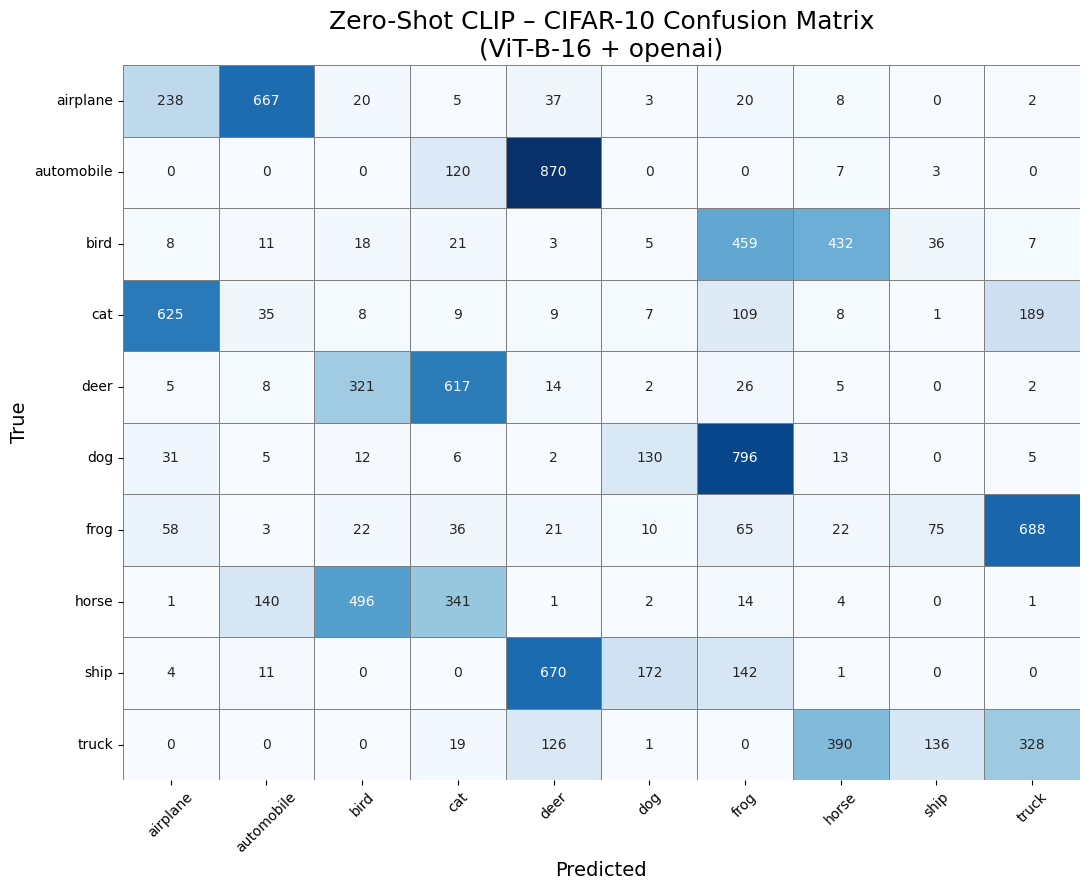

In [42]:
# CELL 6 – ALL METRICS YOU WILL EVER NEED (research-grade)
from sklearn.metrics import (
    classification_report, confusion_matrix, top_k_accuracy_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert everything to numpy once
y_true = true_labels
y_pred = predictions
y_scores = full_scores  # shape (10000, 10)

# 1. Top-k accuracies
top1 = np.mean(y_pred == y_true)
top3 = top_k_accuracy_score(y_true, y_scores, k=3)
top5 = top_k_accuracy_score(y_true, y_scores, k=5)

# 2. All classification metrics
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# 3. Specificity (macro-averaged)
cm = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(10):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
specificity_macro = np.mean(specificity_per_class)

# 4. Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# PRINT EVERYTHING BEAUTIFULLY
print("ZERO-SHOT CIFAR-10 – COMPLETE RESULTS")
print("="*60)
print(f"Top-1 Accuracy       : {top1:.4f}  →  {top1*100:05.2f}%")
print(f"Top-3 Accuracy       : {top3:.4f}  →  {top3*100:05.2f}%")
print(f"Top-5 Accuracy       : {top5:.4f}  →  {top5*100:05.2f}%")
print(f"Balanced Accuracy    : {balanced_acc:.4f}")
print(f"Matthews Corr Coef   : {mcc:.4f}")
print(f"Macro F1-score       : {f1_macro:.4f}")
print(f"Weighted F1-score    : {f1_weighted:.4f}")
print(f"Macro Specificity    : {specificity_macro:.4f}")

# Per-class table (sorted)
df_per_class = pd.DataFrame({
    'Class': cifar10_classes,
    'Accuracy': per_class_acc,
    'Specificity': specificity_per_class
}).sort_values('Accuracy')

print("\nPer-class Accuracy (worst → best)")
print(df_per_class.round(4).to_string(index=False))

# Confusion matrix
plt.figure(figsize=(11, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cifar10_classes, yticklabels=cifar10_classes,
            cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Zero-Shot CLIP – CIFAR-10 Confusion Matrix\n(ViT-B-16 + openai)', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
print(len(y_true))       # should be 10000
print(len(y_scores))


10000
10000


In [40]:
print(len(test_dataset))


10000
